In [34]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings

warnings.filterwarnings("ignore")

SEED = 42

In [35]:
import torch
import pickle
import pandas as pd
from sklearn.metrics import f1_score

In [36]:
embedders = [
    #{'model': 'intfloat/multilingual-e5-small', 'model_ident': 'me5-small'},
    #{'model': 'intfloat/multilingual-e5-base', 'model_ident': 'me5-base'},
    {'model': 'intfloat/multilingual-e5-large', 'model_ident': 'me5-large'},
    {'model': 'deutsche-telekom/gbert-large-paraphrase-cosine', 'model_ident': 't-gbert-lpc'}
]

classifiers = ['svc', 'rfc', 'mlp']

annotators = ["A001", "A002", "A003", "A004", "A005", "A007", "A008", "A009", "A010", "A012"]

In [37]:
def output_st1(predictions):
    #list with columns ["id": ..., "A001": "1.0, "A002": 0.0, "A003": ..., ..., "A012": ...] 
    QUANT_TO_QUAL={0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
    NUMBER_TO_LABEL={0: "0-Kein", 1: "1-Gering", 2: "2-Vorhanden", 3: "3-Stark", 4: "4-Extrem"}

    #predictions_quant: pd.DataFrame = predictions.applymap(lambda x: LABEL_VALS_QUANT[x] if not pd.isna(x) else x)
    predictions_qual: pd.DataFrame = predictions.applymap(lambda x: QUANT_TO_QUAL[x] if not pd.isna(x) else x)

    output = pd.DataFrame(index=["id"])
    output.index = predictions.index

    #create expected columns
    output["bin_maj"] = predictions_qual.mode(axis='columns')[0]
    output["bin_one"] = predictions_qual.apply(lambda x: (x == 1).any(), axis='columns')
    output["bin_all"] = predictions_qual.apply(lambda x: not (x == 0).any(), axis='columns')
    output["multi_maj"] = predictions.mode(axis='columns')[0].apply(lambda x: NUMBER_TO_LABEL[x])
    output["disagree_bin"] = output.apply(lambda x: x["bin_one"] and not x["bin_all"], axis='columns')

    #convert False/True to 0/1
    output['bin_maj'] = output['bin_maj'].apply(lambda x: 1 if x else 0)
    output['bin_one'] = output['bin_one'].apply(lambda x: 1 if x else 0)
    output['bin_all'] = output['bin_all'].apply(lambda x: 1 if x else 0)
    output['disagree_bin'] = output['disagree_bin'].apply(lambda x: 1 if x else 0)

    return output

In [38]:
y_val = pd.read_json("created_data/training_data/y_val.jsonl", lines=True).set_index('id')

scoring=pd.DataFrame(index = [e['model_ident'] for e in embedders], columns=classifiers)

for embedder in embedders:
    embeddings = pd.read_pickle(f"created_data/embeddings/{embedder['model_ident']}.pkl")
    X_val = embeddings.loc[y_val.index]

    for classifier in classifiers:

        classifier_models = {}
        for annotator in annotators:
            with open(f"models/{embedder['model_ident']}_{classifier}_{annotator}.pkl", 'rb') as f:
                model = pickle.load(f)
            classifier_models[annotator] = model

        pred = pd.DataFrame(index=X_val.index, columns=annotators)

        for idx, row in X_val.iterrows():
            correct_annos = y_val.loc[idx].dropna().index
            for anno in correct_annos:
                pred[anno].loc[idx] = classifier_models[anno].predict([row['Embedding']])[0]

        output_correct = output_st1(y_val)
        output_predicted = output_st1(pred)

        col_scorings = []
        for col in output_correct.columns:
            col_scorings.append(f1_score(output_correct[col], output_predicted[col], average='macro'))
        print(f"{embedder['model_ident']}-{classifier}: {col_scorings}")
        scoring.loc[embedder['model_ident']][classifier] = sum(col_scorings) / len(col_scorings)

me5-large-svc: [0.7064294042529565, 0.7382543016059888, 0.6229621748227279, 0.28663421715145315, 0.6314496314496314]
me5-large-rfc: [0.4048311917040756, 0.5462912022603935, 0.45750452079566006, 0.16800386660222327, 0.5178405036346945]
me5-large-mlp: [0.7215337559746157, 0.7303263392653953, 0.6343603505838992, 0.299565357325726, 0.6177945344618427]
t-gbert-lpc-svc: [0.6618494542307505, 0.7277820920697746, 0.553948737330213, 0.2851981675073977, 0.6297205680256528]
t-gbert-lpc-rfc: [0.41027036835420067, 0.5292756690900252, 0.45750452079566006, 0.16800386660222327, 0.5089649479253768]
t-gbert-lpc-mlp: [0.7063101364958604, 0.7312756245644216, 0.6048031615747074, 0.3066897666349388, 0.6141043579373751]


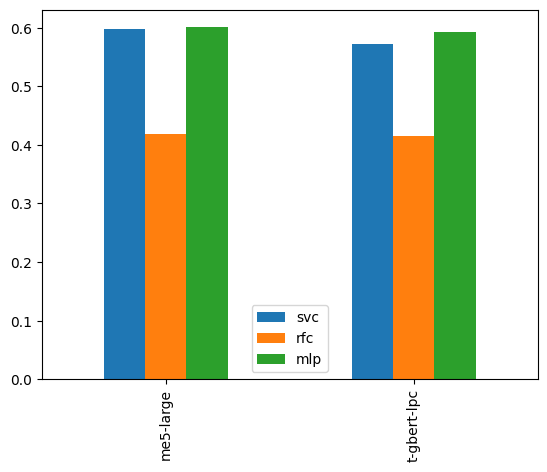

,svc,rfc,mlp
me5-large,0.597146,0.418894,0.600716
t-gbert-lpc,0.5717,0.414804,0.592637


In [39]:
from matplotlib import pyplot as plt

scoring.plot(kind="bar")
plt.show()
scoring